# Kolesa DSML survey analysis

## Introduction

In the end of 2019 Kolesa Group launched a survey among kazakhstani DSML professionals asking about their salary, programming languages, interests and level of analytics in their companies.

[Datasource in Google Sheets](https://docs.google.com/spreadsheets/d/18DyVG1ZA3EJWrl98Z1_pjg9UC6VochIKVgUU_yDlTuM/edit?usp=sharing)

I want to analyze how much 👩 / 👨 answers differ. I use R language.

## TL;DR

On average

* Women earn less than men
* Pay gap is 22%
* Women have less experience
* Women are less skilled in programming languages
* Both sex have about the same responsibilities

Useful links are [here](#bonus)

<font color='red'>**Disclaimer**</font> Conclusions are made only on this survey data and they are not a source of truth.

## Let's go

## Libraries & functions

In [1]:
options(scipen = 99, warn = -1)

In [2]:
suppressMessages(library(googlesheets4))
suppressMessages(library(gargle))
suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggthemr))

In [3]:
ggthemr('flat')

## Reading data from GS

In [4]:
suppressMessages(sheets_auth())

sheet_id <- '18DyVG1ZA3EJWrl98Z1_pjg9UC6VochIKVgUU_yDlTuM'

df <- read_sheet(sheet_id)
glimpse(df)

Using an auto-discovered, cached token.
To suppress this message, modify your code or options to clearly consent to the use of a cached token.
See gargle's "Non-interactive auth" vignette for more details:
https://gargle.r-lib.org/articles/non-interactive-auth.html
The googlesheets4 package is using a cached token for elvira.nassirova@railsware.com.


Auto-refreshing stale OAuth token.

Reading from 'Исследование рынка Data Science и аналитиков в Казахстане_RAW'

Range "Исследование рынка аналитиков"



Observations: 307
Variables: 38
$ `Укажите ваше место жительства:`                                                                 <chr> ...
$ `Сколько вам лет?`                                                                               <dbl> ...
$ `Пол:`                                                                                           <chr> ...
$ `Уровень вашего образования:`                                                                    <chr> ...
$ `Название вашего учебного заведения:`                                                            <chr> ...
$ `Специализация полученного образования:`                                                         <chr> ...
$ `Какими языками вы свободно владеете?`                                                           <chr> ...
$ `Ваш стаж работы в сфере анализа данных:`                                                        <dbl> ...
$ `Общий стаж работы:`                                                                          

In [5]:
df_mod <- 
    df %>% 
    na_if('') %>% 
    dplyr::rename(sex = `Пол:`) %>% 
    mutate(sex = recode(sex, `м` = 'Male', `ж` = 'Female'))

## Question 0: How many of each?

In [6]:
count(df_mod, sex) %>% 
    mutate(share = scales::percent(n/sum(n)))

sex,n,share
<chr>,<int>,<chr>
Female,74,24%
Male,233,76%


## Question 1: How many speak languages do they know?

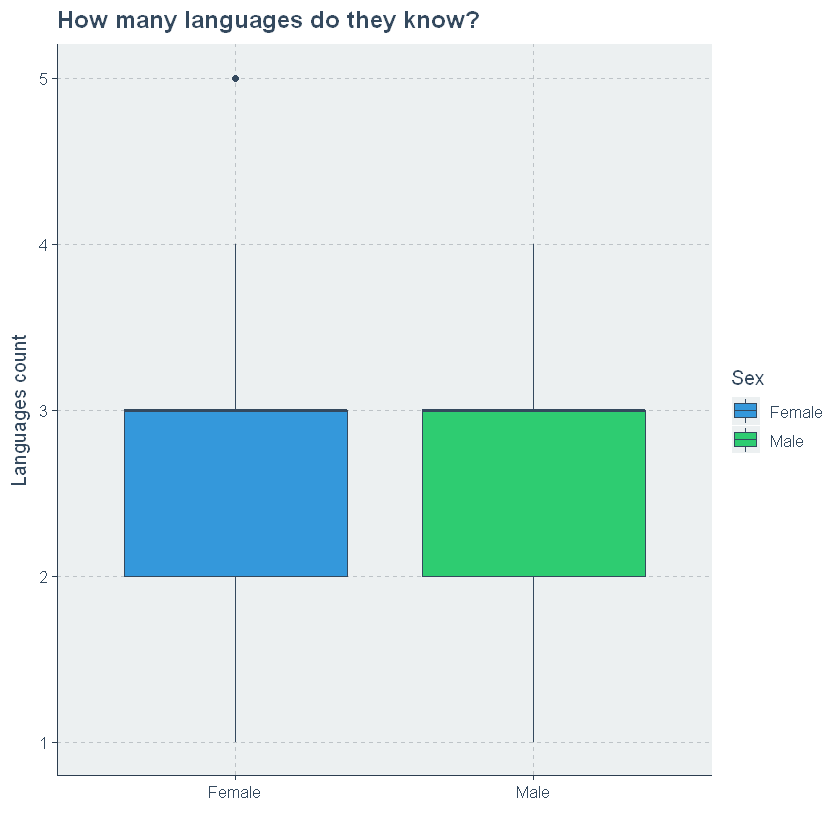

In [7]:
df_mod %>% 
    dplyr::select(sex, languages = `Какими языками вы свободно владеете?`) %>% 
    mutate(lang_cnt = str_count(languages, ',') + 1) %>% 
    ggplot(aes(x = sex, y = lang_cnt, fill = sex)) +
    geom_boxplot() +
    labs(title = 'How many languages do they know?',
        x = '', y = 'Languages count',
        fill = 'Sex')

So, nothing interesting here, except for an outlier on Female side.

## Question 2: How much do they earn?

![img](https://icdn.lenta.ru/images/2018/04/06/00/20180406002902742/detail_52be6d71355bf9f62deda075143ea2d5.jpg)

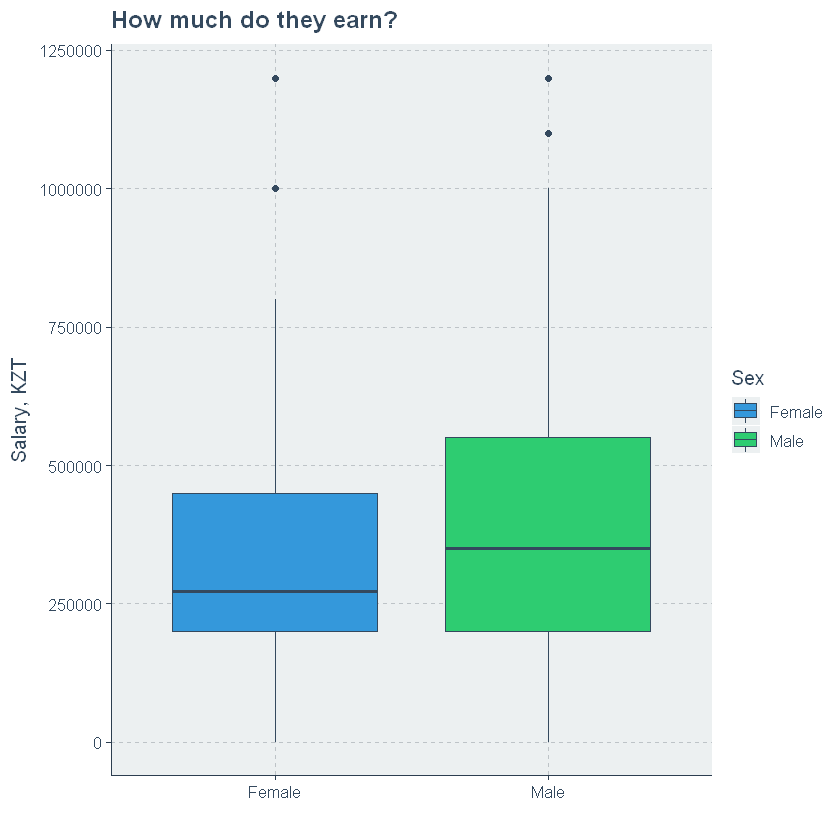

In [8]:
df_mod %>% 
    dplyr::select(sex, salary = `Размер вашей заработной платы в тенге на руки:`) %>% 
    filter(!is.na(salary), 
           between(salary, quantile(salary, .05, na.rm = T), quantile(salary, .95, na.rm = T))) %>% 
    ggplot(aes(x = sex, y = salary, fill = sex)) +
    geom_boxplot() +
    labs(title = 'How much do they earn?',
        x = '', y = 'Salary, KZT',
        fill = 'Sex')

And here we go, women have lower salary than men.

In [9]:
df_salary_stats <- 
    df_mod %>% 
    dplyr::select(sex, salary = `Размер вашей заработной платы в тенге на руки:`) %>% 
    filter(!is.na(salary)) %>% 
    group_by(Sex = sex) %>% 
    summarise(`25%` = quantile(salary, .25),
             Median = median(salary),
             `75%` = quantile(salary, .75)) %>% 
    ungroup

df_salary_stats

Sex,25%,Median,75%
<chr>,<dbl>,<dbl>,<dbl>
Female,150000,272000,450000
Male,197500,350000,600000


In [10]:
df_salary_stats %>% 
    summarise(paygap = scales::percent(1 - min(Median)/max(Median)),
             paygap = paste0('Gender pay gap: ', paygap)) %>% 
    pull(paygap)

[1] "Gender pay gap: 22%"

Gender pay gap of 22% opposed to an average of 32% in Kazakhstan, 2019.

So, maybe women are less skilled or have less experience? Let's check that.

## Question 3: How much do team leads earn?

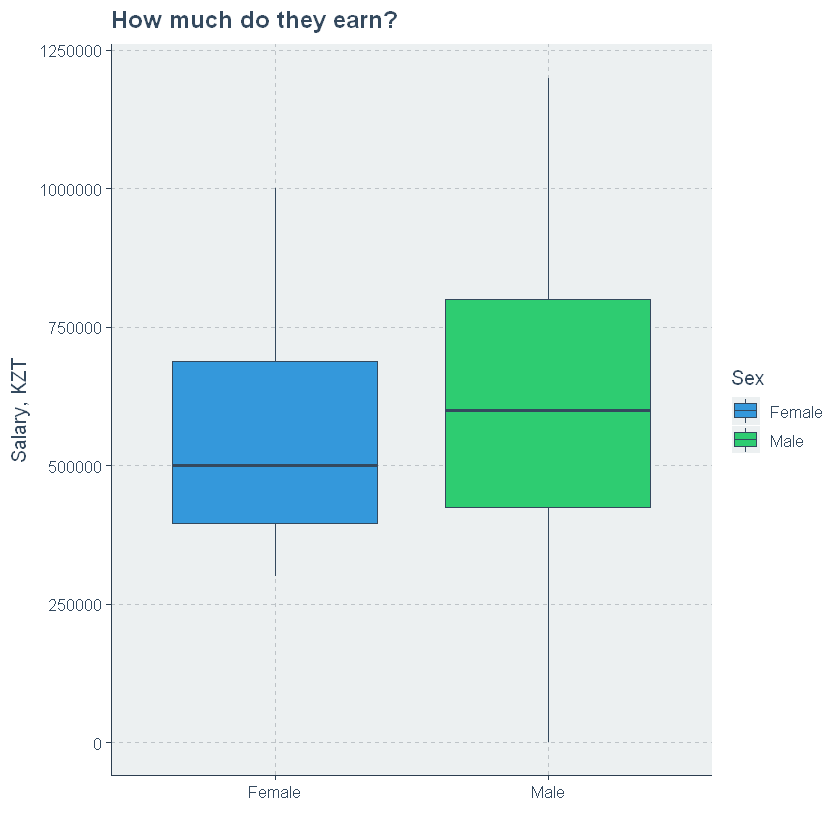

In [11]:
df_mod %>% 
    filter(`Уровень вашей должности:` == 'руководитель или тимлид') %>% 
    dplyr::select(sex, salary = `Размер вашей заработной платы в тенге на руки:`) %>% 
    filter(!is.na(salary), 
           between(salary, quantile(salary, .05, na.rm = T), quantile(salary, .95, na.rm = T))) %>% 
    ggplot(aes(x = sex, y = salary, fill = sex)) +
    geom_boxplot() +
    labs(title = 'How much do they earn?',
        x = '', y = 'Salary, KZT',
        fill = 'Sex')

In [12]:
df_salary_stats <- 
    df_mod %>% 
    filter(`Уровень вашей должности:` == 'руководитель или тимлид') %>% 
    dplyr::select(sex, salary = `Размер вашей заработной платы в тенге на руки:`) %>% 
    filter(!is.na(salary)) %>% 
    group_by(Sex = sex) %>% 
    summarise(`25%` = quantile(salary, .25),
             Median = median(salary),
             `75%` = quantile(salary, .75)) %>% 
    ungroup

df_salary_stats

Sex,25%,Median,75%
<chr>,<dbl>,<dbl>,<dbl>
Female,380000,500000,650000
Male,400000,600000,837500


In [13]:
df_salary_stats %>% 
    summarise(paygap = scales::percent(1 - min(Median)/max(Median)),
             paygap = paste0('Gender pay gap: ', paygap)) %>% 
    pull(paygap)

[1] "Gender pay gap: 17%"

So, even on the same position women earn less money. I assume that to work as a team lead you have to have a certain experience.

## Question 4: How much experience do they have?

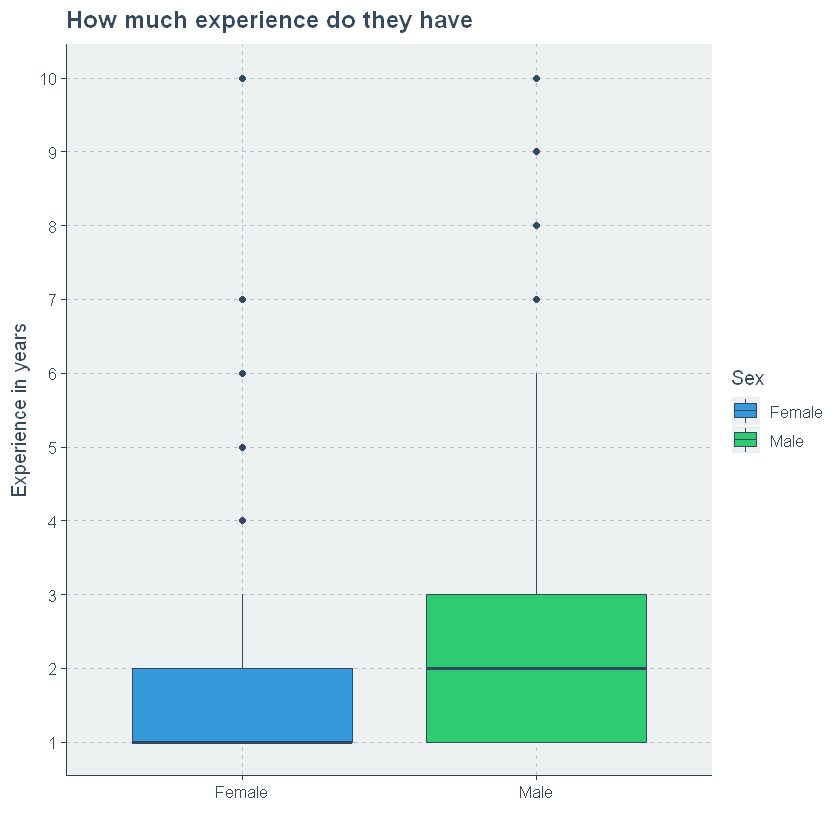

In [14]:
df_mod %>% 
    dplyr::select(sex, experience = `Ваш стаж работы в сфере анализа данных:`) %>% 
    filter(between(experience, quantile(experience, .05, na.rm = T), quantile(experience, .95, na.rm = T))) %>% 
    ggplot(aes(x = sex, y = experience, fill = sex)) +
    geom_boxplot() +
    scale_y_continuous(breaks = seq(1, 10, 1)) +
    labs(title = 'How much experience do they have',
        x = '', y = 'Experience in years',
        fill = 'Sex')

In general women have less experience. Median of 1 year compared to 2 years for men.

## Question 5: How skilled they are?

I am going to compare what languages they use for math and statistics.

In [15]:
df_mod %>% 
    select(sex, tools = `Математические и статистические инструменты:`) %>% 
    tidyr::separate_rows(tools, sep = ',') %>% # some magic happens!
    mutate(tools = str_trim(tools)) %>% 
    count(tools, sex, name = 'users') %>% 
    left_join(count(df_mod, sex)) %>% 
    mutate(share = users / n) %>% 
    group_by(sex) %>% 
    select(sex, tools, share) %>% 
    tidyr::spread(sex, share, fill = 0) %>% 
    filter(!is.na(tools)) %>% 
    arrange(-Female) %>% 
    select_all(str_to_title) %>% 
    mutate_at(vars(contains('male')), ~scales::percent(.))

Joining, by = "sex"


Tools,Female,Male
<chr>,<chr>,<chr>
Excel/Google-таблицы,66%,51%
Python,45%,67%
R,12%,15%
SPSS,9%,8%
не использую,8%,9%
MATLAB,5%,12%
SAS,5%,2%
Statistica,3%,3%
Crm,1%,0%


67% of men use Python, and 66% of women use Excel or Google sheets. 45% of women use Python.

## Question 6: What responsibilities do they have?

In [16]:
df_mod %>% 
    select(sex, functions = `Отметьте три основные функции, которые входят в вашу зону ответственности:`) %>% 
    tidyr::separate_rows(functions, sep = ',') %>% # some magic happens!
    mutate(functions = str_trim(functions)) %>% 
    count(functions, sex, name = 'users') %>% 
    left_join(count(df_mod, sex)) %>% 
    mutate(share = users / n) %>% 
    group_by(sex) %>% 
    select(sex, functions, share) %>% 
    filter(share >= 0.05) %>% 
    tidyr::spread(sex, share, fill = 0) %>% 
    filter(!is.na(functions)) %>% 
    arrange(-Female) %>% 
    select_all(str_to_title) %>% 
    mutate_at(vars(contains('male')), ~scales::percent(.))

Joining, by = "sex"


Functions,Female,Male
<chr>,<chr>,<chr>
базовый статистический анализ,47%,41%
предобработка,42%,53%
чистка и подготовка данных,42%,53%
визуализация и построение дашбордов (BI),36%,30%
выгрузка,32%,34%
загрузка данных (ETL),32%,34%
поддержка инфраструктуры данных (DWH),32%,34%
менеджмент,24%,21%
управление,24%,21%


About the same TOP, we have different proportions for ML/DL and production code and for `поиск точек роста` and `узких мест и трендов на основании данных`. Let's check their titles.

## Question 7: What titles do they have?

In [17]:
count(df_mod, sex, title = `Позиция на текущем месте работы:`, name = 'Count', sort = T) %>% 
    group_by(sex) %>% 
    top_n(3) %>% 
    select_all(str_to_title)

Selecting by Count


Sex,Title,Count
<chr>,<chr>,<int>
Male,Data Scientists,53
Male,BI- аналитик,24
Male,DWH-engineer (Data-engineer),23
Female,Data Scientists,13
Female,маркетинговый аналитик,9
Female,BI- аналитик,6
Female,DWH-engineer (Data-engineer),6


For female we have Marketing analyst in the TOP, so maybe that's why we have previous difference for women.

<a id='bonus'></a>
## Bonus: useful links

In [18]:
select(df_mod, sources = `Напишите топ любимых каналов/блогов/авторов, которые помогают вам в профессиональном развитии.`) %>% 
    tidyr::separate_rows(sources, sep = ',') %>% 
    mutate(sources = str_trim(sources),
         sources = str_to_lower(sources),
         sources = str_remove(sources, '.com|online'),
         sources = str_remove_all(sources, '[:digit:]|[:punct:]|[:space:]')) %>% 
    na_if('') %>% 
    filter(!is.na(sources), !sources %in% c('нет', '-', 'no', '---', '...')) %>% 
    count(sources) %>% 
    arrange(-n) %>% 
    filter(n > 1) %>%     
    select(-n)

sources
<chr>
coursera
habr
medium
towardsdatascience
dsmlkz
ods
sirajraval
stepik
fless
